# Info
Name:  

    NAAMES_cld_comp

Purpose:  

    To compare the various cloud properties retrieved via different methods from NAAMES.
    Looking at the Nov. 17th, 2015 case
  
Input:

    none at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - Sp_parameters.py : for Sp class definition, and for defining the functions used to build parameters
    - load_modis.py : for loading modis files
    - matplotlib
    - numpy
    - scipy : for saving and reading
    - math
    - os
    - gc
    - pdb
    - datetime
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - 20151117_zen_cld_retrieved.mat: cloud retrieval file
  - MYD06_L2.A2015321.1540.006.2015322185040.hdf: MODIS file
  
Modification History:

    Written: Samuel LeBlanc, NASA Ames, Santa Cruz, CA, 2016-03-24
    Modified: 

# Import initial modules and default paths

In [1]:
%config InlineBackend.rc = {}
import matplotlib 
matplotlib.rc_file('C:\\Users\\sleblan2\\Research\\python_codes\\file.rc')
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import scipy.io as sio
import Sp_parameters as Sp
import hdf5storage as hs
import load_modis as lm

In [16]:
from mpl_toolkits.basemap import Basemap,cm

In [64]:
import write_utils as wu

In [2]:
%matplotlib notebook

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
# set the basic directory path
fp='C:/Users/sleblan2/Research/NAAMES/'

# Load the various data

## Load the retrieved cloud properties from 4STAR

In [4]:
star = hs.loadmat(fp+'retrieve/20151117_zen_cld_retrieved.mat')

In [5]:
star.keys()

[u'tau', u'utc', u'ki', u'sza', u'lon', u'lat', u'phase', u'alt', u'ref']

<IPython.core.display.Javascript object>


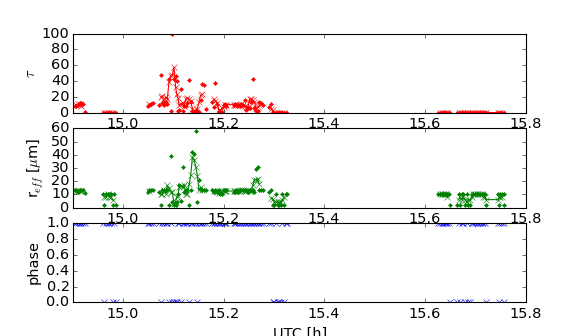

In [131]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(star['utc'],star['tau'],'r.')
plt.plot(star['utc'],Sp.smooth(star['tau'],4,nan=False),'-xr')
plt.ylabel('$\\tau$')
plt.subplot(3,1,2)
plt.plot(star['utc'],star['ref'],'g.')
plt.plot(star['utc'],Sp.smooth(star['ref'],4,nan=False),'-xg')
plt.ylabel('r$_{eff}$ [$\\mu$m]')
plt.subplot(3,1,3)
plt.plot(star['utc'],star['phase'],'x')
plt.ylabel('phase')
plt.xlabel('UTC [h]')

In [132]:
star['tau'] = Sp.smooth(star['tau'],4,nan=False)
star['ref'] = Sp.smooth(star['ref'],4,nan=False)

## Load the MODIS file

In [13]:
myd3 = fp+'c130/20151117_flt/MYD03.A2015321.1540.006.2015322160400.hdf'
myd6 = fp+'c130/20151117_flt/MYD06_L2.A2015321.1540.006.2015322185040.hdf'

In [14]:
modis,modis_dicts = lm.load_modis(myd3,myd6)

Outputting the Geo subdatasets:
0: [4060x2708] Scan Offset MODIS_Swath_Type_GEO (8-bit integer)
1: [4060x2708] Track Offset MODIS_Swath_Type_GEO (8-bit integer)
2: [4060x2708] Height Offset MODIS_Swath_Type_GEO (8-bit integer)
3: [2030x1354] Height MODIS_Swath_Type_GEO (16-bit integer)
4: [2030x1354] SensorZenith MODIS_Swath_Type_GEO (16-bit integer)
5: [2030x1354] SensorAzimuth MODIS_Swath_Type_GEO (16-bit integer)
6: [2030x1354] Range MODIS_Swath_Type_GEO (16-bit unsigned integer)
7: [2030x1354] SolarZenith MODIS_Swath_Type_GEO (16-bit integer)
8: [2030x1354] SolarAzimuth MODIS_Swath_Type_GEO (16-bit integer)
9: [2030x1354] Land/SeaMask MODIS_Swath_Type_GEO (8-bit unsigned integer)
10: [2030x1354] WaterPresent MODIS_Swath_Type_GEO (8-bit unsigned integer)
11: [2030x1354] gflags MODIS_Swath_Type_GEO (8-bit unsigned integer)
12: [2030x1354] Latitude (32-bit floating-point)
13: [2030x1354] Longitude (32-bit floating-point)
14: [4060x2708] Scan Offset (8-bit integer)
15: [4060x2708] Trac

## Load the insitu probe liquid vs ice water content

In [42]:
help(lm.load_ict)

Help on function load_ict in module load_modis:

load_ict(fname, return_header=False, make_nan=True)
    Simple ict file loader
    created specifically to load the files from the iwg1 on board the G1 during TCAP, may work with others...
    inputs:
       fname: filename with full path
       return_header: (default set to False) if True, returns data, header in that form
       make_nan: (default set to True) if True, the values defined in the header to be missing data, usually -999, is changed to NaNs



In [43]:
wf = fp+'c130/20151117_flt/NAAMES-LARGE-WCM_C130_20151117_RA.ict'
wcm,wcm_head = lm.load_ict(wf,return_header=True)

('Date_UTC', 'TWC_gm_3', 'LWC1_gm_3', 'LWC2_gm_3')


<IPython.core.display.Javascript object>


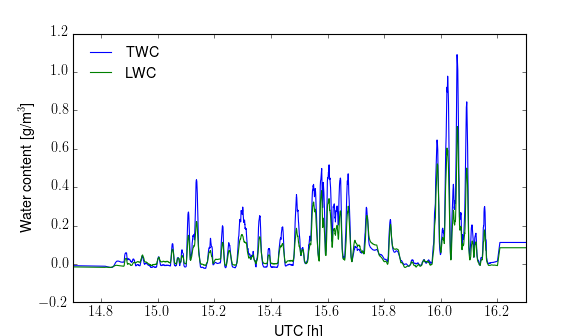

In [57]:
plt.figure()
plt.plot(wcm['Date_UTC']/3600,Sp.smooth(wcm['TWC_gm_3'],30),label='TWC')
plt.plot(wcm['Date_UTC']/3600,Sp.smooth(wcm['LWC1_gm_3'],30),label='LWC')
plt.ylabel('Water content [g/m$^3$]')
plt.xlabel('UTC [h]')
plt.xlim([14.7,16.3])
plt.legend(frameon=False,loc=2)

# Start plotting MODIS and the retrieved values

In [31]:
#set up a easy plotting function
def naames_map(ax=plt.gca()):
    m = Basemap(projection='stere',lon_0=-40,lat_0=50,
            llcrnrlon=-42, llcrnrlat=48,
            urcrnrlon=-37, urcrnrlat=52,resolution='h',ax=ax)
    m.drawcoastlines()
    #m.fillcontinents(color='#AAAAAA')
    m.drawstates()
    m.drawcountries()
    m.drawmeridians(np.linspace(-35,-45,11),labels=[0,0,0,1])
    m.drawparallels(np.linspace(45,55,11),labels=[1,0,0,0])
    return m

<IPython.core.display.Javascript object>


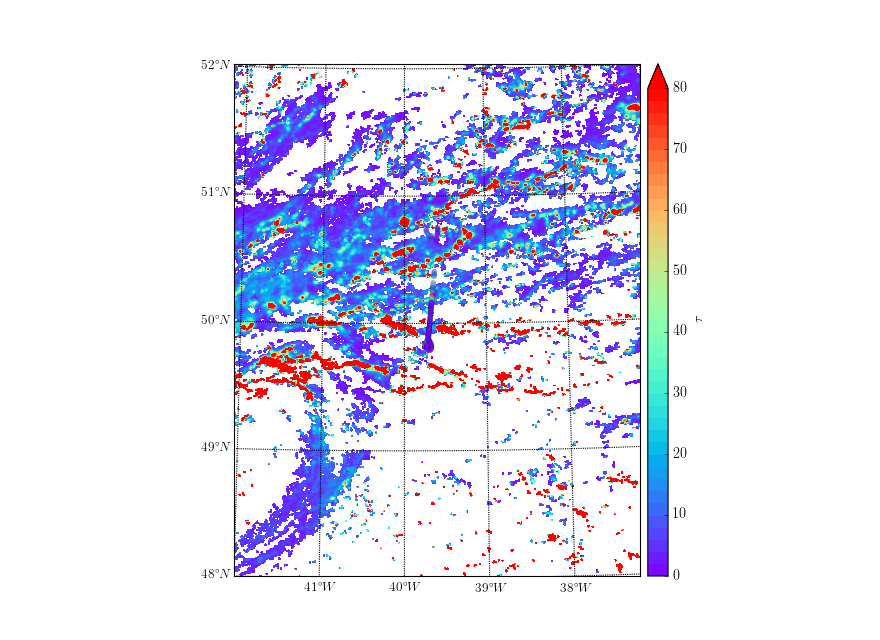

In [33]:
fig,ax = plt.subplots(1,1,figsize=(11,8))
m = naames_map(ax)
x,y = m(modis['lon'],modis['lat'])
clevels = np.linspace(0,80,41)

cs1 = m.contourf(x,y,modis['tau'],clevels,cmap=plt.cm.rainbow,extend='max')
cbar = m.colorbar(cs1)
cbar.set_label('$\\tau$')

xx,yy = m(star['lon'],star['lat'])
m.scatter(xx,yy,c=star['tau'],cmap=plt.cm.rainbow,marker='o',vmin=clevels[0],vmax=clevels[-1],
          alpha=0.5,edgecolors='k',linewidth=0.25)


<IPython.core.display.Javascript object>


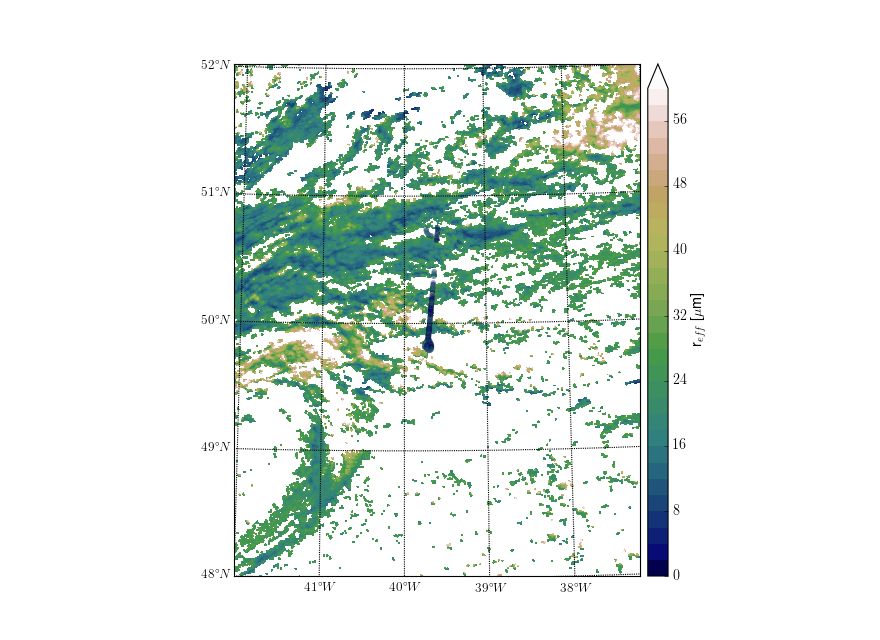

In [34]:
fig,ax = plt.subplots(1,1,figsize=(11,8))
m = naames_map(ax)
x,y = m(modis['lon'],modis['lat'])
clevels = np.linspace(0,60,31)

cs1 = m.contourf(x,y,modis['ref'],clevels,cmap=plt.cm.gist_earth,extend='max')
cbar = m.colorbar(cs1)
cbar.set_label('r$_{eff}$ [$\\mu$m]')

xx,yy = m(star['lon'],star['lat'])
m.scatter(xx,yy,c=star['ref'],cmap=plt.cm.gist_earth,marker='o',vmin=clevels[0],vmax=clevels[-1],
          alpha=0.5,edgecolors='k',linewidth=0.25)

In [36]:
modis_dicts['phase']

{'ALGORITHMPACKAGEACCEPTANCEDATE': 'June 1997',
 'ALGORITHMPACKAGEMATURITYCODE': 'at-launch',
 'ALGORITHMPACKAGENAME': 'ATBD-MOD-04 and ATBD-MOD-05',
 'ALGORITHMPACKAGEVERSION': '2',
 'ALGORITHM_VERSION_CLOUD_PHASE_IR': '1',
 'ALGORITHM_VERSION_CLOUD_PROPERTY_VIS': '1',
 'ALGORITHM_VERSION_CLOUD_TOP_PROPERTY_IR': '1',
 'ANCILLARYINPUTPOINTER': 'MYD03.A2015321.1540.006.2015322160400.hdf',
 'ANCILLARYINPUTTYPE': 'Geolocation',
 'ASSOCIATEDINSTRUMENTSHORTNAME': 'MODIS',
 'ASSOCIATEDPLATFORMSHORTNAME': 'Aqua',
 'ASSOCIATEDSENSORSHORTNAME': 'MODIS',
 'AUTOMATICQUALITYFLAG': 'Passed',
 'AUTOMATICQUALITYFLAGEXPLANATION': 'Passed: >10% useable; Failed: <10% useable',
 'Cell_Across_Swath_Sampling': '1, 1354, 1',
 'Cell_Along_Swath_Sampling': '1, 2030, 1',
 'CirrusCloudDetectedPct_IR': '   41.25',
 'Clear_Sky_Restoral_Status': 'y',
 'CloudPhaseUncertainPct_IR': '   35.02',
 'Collection_4_Phase_Used': 'n',
 'DAYNIGHTFLAG': 'Day',
 'DESCRREVISION': '6.0',
 'EASTBOUNDINGCOORDINATE': '-24.3883177545

<IPython.core.display.Javascript object>


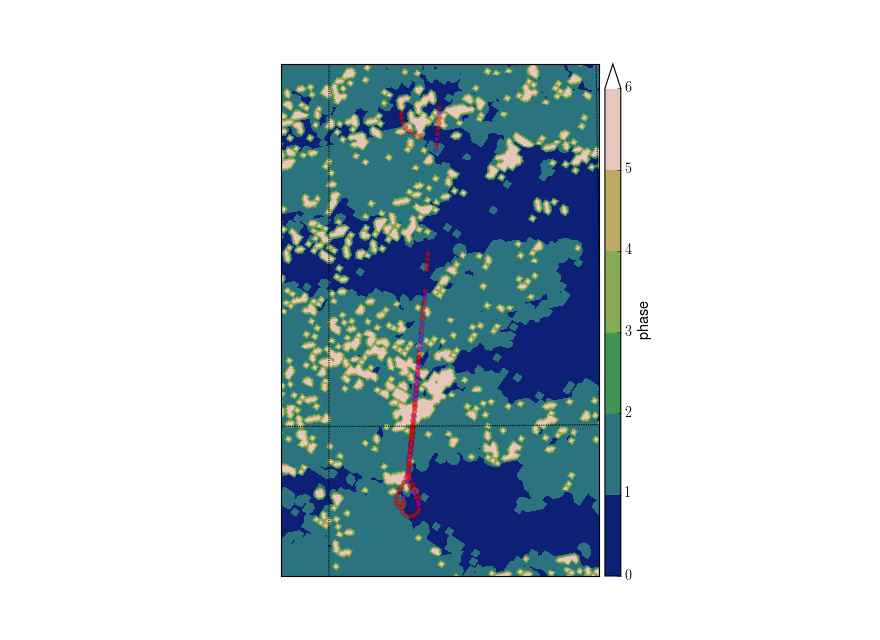

In [40]:
fig,ax = plt.subplots(1,1,figsize=(11,8))
m = naames_map(ax)
x,y = m(modis['lon'],modis['lat'])
clevels = np.linspace(0,6,7)

cs1 = m.contourf(x,y,modis['phase'],clevels,cmap=plt.cm.gist_earth,extend='max')
cbar = m.colorbar(cs1)
cbar.set_label('phase')

xx,yy = m(star['lon'],star['lat'])
m.scatter(xx,yy,c=star['phase'],cmap=plt.cm.rainbow,marker='o',vmin=0,vmax=1,
          alpha=0.5,edgecolors='k',linewidth=0.25)

## Subset the MODIS values to match the flight path

In [158]:
import map_utils as mu

In [159]:
mod_ind = mu.map_ind(modis['lon'],modis['lat'],star['lon'],star['lat'])

Running through flight track: [########################################]100% -- Done! 


In [160]:
mod_ind.shape

(2L, 340L)

In [168]:
modis['lat'].shape

(2030L, 1354L)

In [161]:
star['lat'].shape

(340L, 1L)

In [189]:
star['tau'][star['tau']<1.0] = np.nan

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


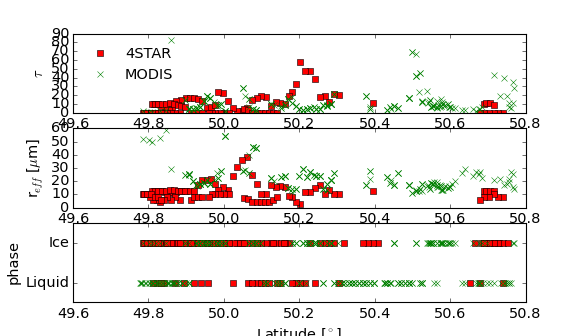

In [187]:
plt.figure()
ax = plt.subplot(3,1,1)
plt.plot(star['lat'],star['tau'],'rs',label='4STAR')
plt.plot(modis['lat'][mod_ind[0,:],mod_ind[1,:]],modis['tau'][mod_ind[0,:],mod_ind[1,:]],'gx',label='MODIS')
plt.legend(frameon=False,numpoints=1,loc=0)
plt.ylabel('$\\tau$')
plt.subplot(3,1,2,sharex=ax)
plt.plot(star['lat'],star['ref'],'rs')
plt.plot(modis['lat'][mod_ind[0,:],mod_ind[1,:]],modis['ref'][mod_ind[0,:],mod_ind[1,:]],'gx',label='MODIS')
plt.ylabel('r$_{eff}$ [$\\mu$m]')
ax3 = plt.subplot(3,1,3,sharex=ax)
plt.plot(star['lat'],star['phase'],'rs')
plt.plot(modis['lat'][mod_ind[0,:],mod_ind[1,:]],modis['phase'][mod_ind[0,:],mod_ind[1,:]]-1,'gx',label='MODIS')
plt.ylim([-0.5,1.5])
plt.yticks([0,1])
ax3.set_yticklabels(['Liquid','Ice'])
plt.ylabel('phase')
plt.xlabel('Latitude [$^\circ$]')
plt.savefig(fp+'plot/20151117_cld_retr_vs_MODIS.png',transparent=True,dpi=600)

## Now compare MODIS vs. 4STAR with bean plots

In [183]:
import plotting_utils as pu

<IPython.core.display.Javascript object>


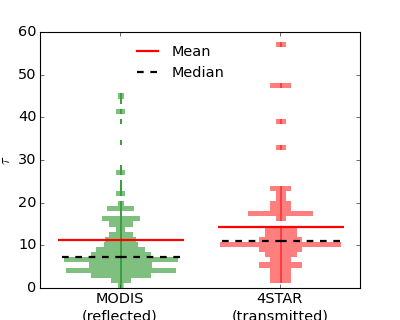

In [193]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,60],xlim=[-0.5,1.5])
ax1.set_ylabel('$\\tau$')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis['tau'][mod_ind[0,:],mod_ind[1,:]],0,[0,60],legend=True,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star['tau'],1,[0,60],legend=True,color='r',bins=50)
plt.savefig(fp+'plot/20151117_COD_bean_modis_4star.png',transparent=True,dpi=600)

<IPython.core.display.Javascript object>


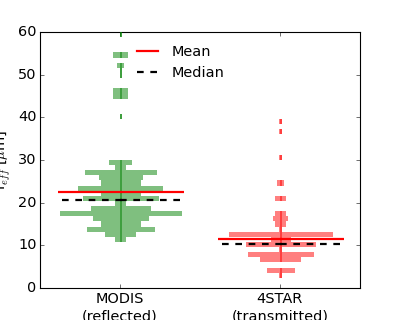

In [194]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8],ylim=[0,60],xlim=[-0.5,1.5])
ax1.set_ylabel('r$_{eff}$ [$\\mu$m]')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['MODIS\n(reflected)','4STAR\n(transmitted)'])
pu.plot_vert_hist(fig,ax1,modis['ref'][mod_ind[0,:],mod_ind[1,:]],0,[0,60],legend=True,onlyhist=False,loc=2,color='g',bins=50)
pu.plot_vert_hist(fig,ax1,star['ref'],1,[0,60],legend=True,color='r',bins=50)
plt.savefig(fp+'plot/20151117_ref_bean_modis_4star.png',transparent=True,dpi=600)

# Now prepare a subsection of retrieved values to be saved in ict

## create the dicts for writing to ict

In [60]:
star.keys()

[u'tau', u'utc', u'ki', u'sza', u'lon', u'lat', u'phase', u'alt', u'ref']

In [241]:
d_dict =  {'utc':{'data':star['utc'],'unit':'hours from midnight UTC',
                     'long_description':'Fractional hours starting a midnight, continuous'},
          'COD':{'data':star['tau'],'unit':'None','format':'.1f',
                 'long_description':'Cloud Optical Depth of the cloud above the Aircraft'},
          'REF':{'data':star['ref'],'unit':'microns','format':'.1f',
                 'long_description':'Cloud particle effective radius, pertains to liquid cloud drops and ice crystals'},
          'PHASE':{'data':star['phase'],'unit':'None','format':'.0f',
                   'long_description':'Thermodynamic phase of cloud above, 0: pure liquid cloud, 1: pure ice cloud, mixed phase not retrieved'},
          'LAT':{'data':star['lat'],'unit':'Degrees','format':'.6f',
                 'long_description':'Aircraft position latitude (North positive)'},
          'LON':{'data':star['lon'],'unit':'Degrees','format':'.6f',
                 'long_description':'Aircraft position longitude (East positive)'},
          'ALT':{'data':star['alt'],'unit':'meter','format':'.1f',
                 'long_description':'Aircraft altitude'},
          'SZA':{'data':star['sza'],'unit':'Degrees','format':'.2f',
                 'long_description':'Solar Zenith Angle, angle of the sun between it and zenith'}
          }

In [242]:
h_dict ={'PI':'Jens Redemann',
         'Institution':'NASA Ames Research Center',
         'Instrument':'4STAR',
         'campaign':'NAAMES #1',
         'special_comments':'Preliminary retrieved cloud properties data',
         'PI_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'platform':'C130',
         'location':"based out of St-John's, NL, Canada, actual location of C130 described by lat and lon below",
         'instrument_info':'Retrieved products from the 4STAR zenith radiance measurements',
         'data_info':'For references see LeBlanc et al.(2015) AMT, doi:10.5194/amt-8-1361-2015',
         'time_interval':10.0,
         'uncertainty':'Preliminary 7% in REF and 5% in COD',
         'DM_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'project_info':'NAAMES field mission',
         'stipulations':'Prior OK from PI',
         'rev_comments':"""RA: preliminary retrieved values, may be subject to multiple errors
    including due to clouds influencing presumed surface albedo, non-homogeneous clouds, or mixed phase clouds"""
        }

In [243]:
order=['LAT','LON','ALT','SZA','COD','REF','PHASE']

## Verify the input, plot and write the file. Subset only valid time.

In [244]:
data_dict = wu.prep_data_for_ict(d_dict,Start_UTC=15.04,End_UTC=15.34,time_interval=10.0)

In [143]:
data_dict.keys()

['Start_UTC', 'SZA', 'LON', 'LAT', 'COD', 'PHASE', 'ALT', 'REF']

<IPython.core.display.Javascript object>


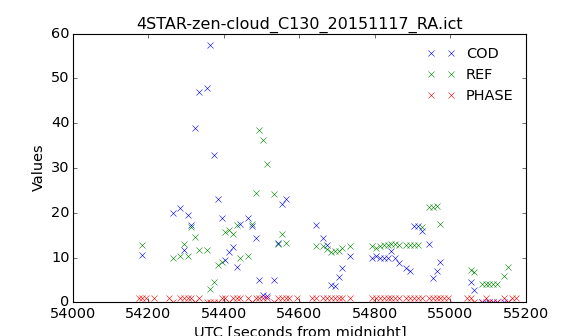

plotting the togethers


<IPython.core.display.Javascript object>


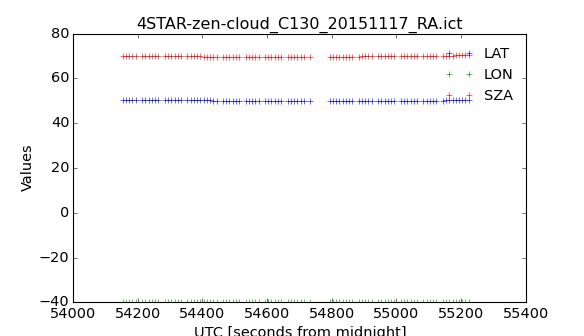

plotting the togethers 2


<IPython.core.display.Javascript object>


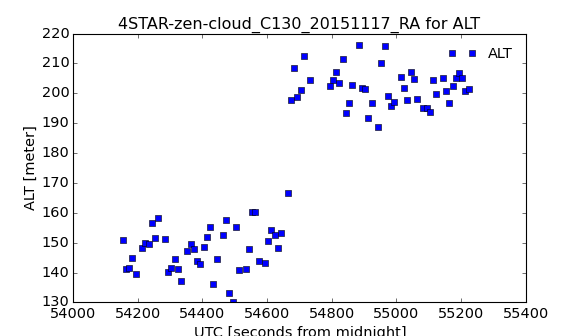

plotting ALT


In [154]:
wu.make_plots_ict(data_dict,filepath=fp+'plot/',data_id='4STAR-zen-cloud',loc_id='C130',date='20151117',rev='RA',
                  plot_together=['COD','REF','PHASE'],plot_together2=['LAT','LON','SZA'])

In [245]:
wu.write_ict(h_dict,data_dict,filepath=fp,data_id='4STAR-zen-cloud',loc_id='C130',date='20151117',rev='RA',order=order)

LAT
LON
ALT
SZA
COD
REF
PHASE
File writing successful to: C:/Users/sleblan2/Research/NAAMES/4STAR-zen-cloud_C130_20151117_RA.ict


## Now prepare the same values but from MODIS

In [246]:
md_dict =  {'utc':{'data':star['utc'],'unit':'hours from midnight UTC',
                     'long_description':'Fractional hours starting a midnight, continuous'},
          'COD':{'data':modis['tau'][mod_ind[0,:],mod_ind[1,:]],'unit':'None','format':'.1f',
                 'long_description':'Cloud Optical Depth from MODIS'},
          'REF':{'data':modis['ref'][mod_ind[0,:],mod_ind[1,:]],'unit':'microns','format':'.1f',
                 'long_description':'Cloud particle effective radius, pertains to liquid cloud drops and ice crystals'},
          'PHASE':{'data':modis['phase'][mod_ind[0,:],mod_ind[1,:]],'unit':'None','format':'.0f',
                   'long_description':'Thermodynamic phase of cloud,'+\
                   ' 0 -- cloud free, 1 -- water cloud, 2 -- ice cloud, 3 -- mixed phase cloud, 6 -- undetermined phase'},
          'LAT':{'data':modis['lat'][mod_ind[0,:],mod_ind[1,:]],'unit':'Degrees','format':'.6f',
                 'long_description':'MODIS linked to Aircraft position latitude (North positive)'},
          'LON':{'data':modis['lon'][mod_ind[0,:],mod_ind[1,:]],'unit':'Degrees','format':'.6f',
                 'long_description':'MODIS linked to Aircraft position longitude (East positive)'},
          'SZA':{'data':star['sza'],'unit':'Degrees','format':'.2f',
                 'long_description':'Solar Zenith Angle, angle of the sun between it and zenith'}
          }

In [247]:
mh_dict ={'PI':'Samuel LeBlanc',
         'Institution':'NASA Ames Research Center',
         'Instrument':'MODIS',
         'campaign':'NAAMES #1',
         'special_comments':'MODIS retrieved cloud values linked along C130 flight path',
         'PI_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'platform':'C130',
         'location':"based out of St-John's, NL, Canada, actual location of C130 described by lat and lon below",
         'instrument_info':'Retrieved products from the MODIS, MYD06_L2.A2015321.1540.006.2015322185040.hdf',
         'data_info':'For references see LeBlanc et al.(2015) AMT, doi:10.5194/amt-8-1361-2015',
         'time_interval':10.0,
         'uncertainty':'N\A',
         'DM_contact':'Samuel LeBlanc, samuel.leblanc@nasa.gov',
         'project_info':'NAAMES field mission',
         'stipulations':'Prior OK from PI',
         'rev_comments':"""RA: initial go at this, for radiative transfer calculations"""
        }

In [248]:
order=['LAT','LON','SZA','COD','REF','PHASE']

In [249]:
mdata_dict = wu.prep_data_for_ict(md_dict,Start_UTC=15.04,End_UTC=15.34,time_interval=10.0)

In [250]:
wu.write_ict(mh_dict,mdata_dict,filepath=fp,data_id='MODIS-cloud-to-C130',loc_id='C130',date='20151117',rev='RA',order=order)

LAT
LON
SZA
COD
REF
PHASE
File writing successful to: C:/Users/sleblan2/Research/NAAMES/MODIS-cloud-to-C130_C130_20151117_RA.ict


# Prepare input files for radiative transfer

In [222]:
import Run_libradtran as Rl

## Prepare the defaults

In [226]:
from datetime import datetime
datetime(2015,11,17).timetuple().tm_yday

321

In [227]:
geo = {'lat':47.6212167,'lon':52.74245,'doy':321,'zout':[0,100.0]}
aero = {} # none
cloud = {'ztop':2.5,'zbot':2.0,'write_moments_file':False}
source = {'wvl_range':[201.0,4000.0],'source':'solar','integrate_values':True,'run_fuliou':True,
          'dat_path':'/u/sleblan2/libradtran/libRadtran-2.0-beta/data/'}
albedo = {'create_albedo_file':False,'sea_surface_albedo':True,'wind_speed':10.0}

In [ ]:
cloud['phase'] = 'wc'
geo['sza'] = 40.0
cloud['tau'] = 2.0
cloud['ref'] = 5.0

In [232]:
phase_star = {0:'wc',1:'ic'}

In [233]:
phase_modis = {0:'wc',1:'wc',2:'ic',3:'ic',6:'wc'}

## Make the runs for 4STAR

In [251]:
data_dict['COD']['data']

array([    nan,     nan,     nan,     nan,  10.5  ,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,  20.   ,     nan,
        21.   ,  11.75 ,  19.5  ,  17.375,  38.875,  46.875,     nan,
        47.875,  57.5  ,  32.875,  23.   ,  18.75 ,   9.375,  11.25 ,
        12.375,   7.875,  17.5  ,     nan,  18.75 ,  17.125,  14.375,
         5.   ,   1.575,   1.325,     nan,   5.075,  13.2  ,  21.875,
        23.   ,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,  17.25 ,     nan,  14.375,  12.8  ,   3.8  ,   3.55 ,
         5.675,   7.75 ,     nan,  10.25 ,     nan,     nan,     nan,
           nan,     nan,  10.   ,  10.25 ,  10.   ,  10.   ,  10.   ,
        11.5  ,  10.   ,   8.75 ,     nan,   7.75 ,   7.   ,  17.   ,
        17.   ,  15.875,     nan,  13.   ,   5.5  ,   7.   ,   9.125,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
         4.55 ,   2.825,     nan,     nan,     nan,     nan,     nan,
           nan,     

In [252]:
data_dict['PHASE']['data']

array([ nan,  nan,  nan,   1.,   1.,   1.,  nan,   1.,  nan,  nan,  nan,
         1.,   0.,  nan,   1.,   1.,   1.,   1.,   0.,   1.,  nan,   0.,
         0.,   0.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,  nan,   1.,
         0.,   1.,   1.,   1.,   1.,  nan,   0.,   1.,   1.,   1.,   1.,
        nan,   1.,  nan,  nan,  nan,   1.,   1.,  nan,   1.,   1.,   1.,
         1.,   1.,   1.,  nan,   1.,  nan,  nan,  nan,  nan,  nan,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,  nan,   1.,   1.,   1.,
         1.,   1.,  nan,   1.,   1.,   1.,   1.,   1.,   1.,  nan,  nan,
        nan,  nan,   1.,   1.,   0.,  nan,   0.,   1.,   0.,   0.,   0.,
        nan,   1.,   0.,   1.,   1.,  nan,  nan,  nan,  nan,  nan])

In [253]:
data_dict['REF']['data']

array([   nan,    nan,    nan,    nan,  12.75,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,  10.  ,    nan,  10.25,  13.  ,
        10.25,  16.75,  14.5 ,  11.75,    nan,  11.75,   3.  ,   4.5 ,
         8.25,   9.  ,  15.75,  16.25,  15.25,  17.25,  10.  ,    nan,
        10.25,  17.5 ,  24.5 ,  38.5 ,  36.25,  31.  ,    nan,  24.25,
        13.  ,  15.25,  13.25,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,  12.5 ,    nan,  12.5 ,  12.  ,  11.25,  11.5 ,
        11.5 ,  12.25,    nan,  12.5 ,    nan,    nan,    nan,    nan,
          nan,  12.5 ,  12.25,  12.5 ,  12.75,  12.75,  13.  ,  13.  ,
        12.75,    nan,  12.75,  12.75,  12.75,  12.75,  16.75,    nan,
        21.25,  21.25,  21.5 ,  17.5 ,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,   7.25,   6.75,    nan,   4.  ,   4.  ,
         4.  ,   4.  ,   4.  ,    nan,   6.  ,   8.  ,    nan,    nan,
          nan,    nan,    nan,    nan,    nan])

In [269]:
# open the list file
f = open(fp+'rtm/NAAMES_20151117_CRE.sh','w')
fpp_in = '/nobackup/sleblan2/rtm/input/NAAMES_CRE_20151117/'
fpp_out = '/nobackup/sleblan2/rtm/output/NAAMES_CRE_20151117/'
fp_uv = '/u/sleblan2/libradtran/libRadtran-2.0-beta/bin/uvspec'
fp_in = fp+'rtm/input/CRE/'

In [270]:
for i,l in enumerate(data_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(data_dict['PHASE']['data'][i]) or not np.isfinite(data_dict['COD']['data'][i]):
        continue
    print i
    
    f_in = 'NAAMES_v1_star_{:03d}.dat'.format(i)
    geo['lat'],geo['lon'],geo['sza'] = l,data_dict['LON']['data'][i],data_dict['SZA']['data'][i]
    cloud['tau'],cloud['ref'] = data_dict['COD']['data'][i],data_dict['REF']['data'][i]
    cloud['phase'] = phase_star[data_dict['PHASE']['data'][i]]
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
    
    f_in = 'NAAMES_v1_star_{:03d}_clear.dat'.format(i)
    cloud['tau'] = 0.0
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    f.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
f.close()

4
12
14
15
16
17
18
19
21
22
23
24
25
26
27
28
29
30
32
33
34
35
36
37
39
40
41
42
50
52
53
54
55
56
57
59
65
66
67
68
69
70
71
72
74
75
76
77
78
80
81
82
83
91
92


C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


## Make the runs for MODIS

In [271]:
# open the list file
fm = open(fp+'rtm/NAAMES_20151117_CRE_modis.sh','w')
fpp_in = '/nobackup/sleblan2/rtm/input/NAAMES_CRE_20151117/'
fpp_out = '/nobackup/sleblan2/rtm/output/NAAMES_CRE_20151117/'
fp_uv = '/u/sleblan2/libradtran/libRadtran-2.0-beta/bin/uvspec'
fp_in = fp+'rtm/input/CRE/'

In [272]:
for i,l in enumerate(mdata_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(mdata_dict['PHASE']['data'][i]) or not np.isfinite(mdata_dict['COD']['data'][i]):
        continue
    print i
    
    f_in = 'NAAMES_v1_modis_{:03d}.dat'.format(i)
    geo['lat'],geo['lon'],geo['sza'] = l,mdata_dict['LON']['data'][i],mdata_dict['SZA']['data'][i]
    cloud['tau'],cloud['ref'] = mdata_dict['COD']['data'][i],mdata_dict['REF']['data'][i]
    cloud['phase'] = phase_modis[mdata_dict['PHASE']['data'][i]]
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    fm.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
    
    f_in = 'NAAMES_v1_modis_{:03d}_clear.dat'.format(i)
    cloud['tau'] = 0.0
    Rl.write_input_aac(fp_in+f_in,geo=geo,aero=aero,cloud=cloud,source=source,albedo=albedo,
                               verbose=False,make_base=False,set_quiet=True)
    fm.write('{uv} < {fin} > {out}\n'.format(uv=fp_uv,fin=fpp_in+f_in,out=fpp_out+f_in))
fm.close()

4
12
14
15
16
17
18
19
21
22
23
24
25
26
28
32
33
34
35
40
41
42
43
45
46
47
48
55
65
66
68
71
76
77
78
80
81
82
83
84
85
87
92
94
95
96
100
103
104
105
106
107
108


C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


# Read the output files (after running on pleaides)

In [276]:
nstar = len(data_dict['LAT']['data'])
nmodis = len(mdata_dict['LAT']['data'])
star_CRE = {'dn':np.zeros((nstar,2)),'up':np.zeros((nstar,2))}
star_CRE_clear = {'dn':np.zeros((nstar,2)),'up':np.zeros((nstar,2))}
modis_CRE = {'dn':np.zeros((nmodis,2)),'up':np.zeros((nmodis,2))}
modis_CRE_clear = {'dn':np.zeros((nmodis,2)),'up':np.zeros((nmodis,2))}

In [277]:
for i,l in enumerate(mdata_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(mdata_dict['PHASE']['data'][i]) or not np.isfinite(mdata_dict['COD']['data'][i]):
        continue
    print i
    f_in = 'NAAMES_v1_modis_{:03d}.dat'.format(i)
    s = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
    f_in = 'NAAMES_v1_modis_{:03d}_clear.dat'.format(i)
    sc = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
    
    modis_CRE['dn'][i,:] = s['diffuse_down']+s['direct_down']
    modis_CRE_clear['dn'][i,:] = sc['diffuse_down']+sc['direct_down']
    modis_CRE['up'][i,:] = s['diffuse_up']
    modis_CRE_clear['up'][i,:] = sc['diffuse_up']
    

4


C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


ValueError: total size of new array must be unchanged

In [ ]:
for i,l in enumerate(data_dict['LAT']['data']):
    if l<-100.: # for only valid values
        continue
    if not np.isfinite(data_dict['PHASE']['data'][i]) or not np.isfinite(data_dict['COD']['data'][i]):
        continue
    print i
    f_in = 'NAAMES_v1_star_{:03d}.dat'.format(i)
    s = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
    f_in = 'NAAMES_v1_star_{:03d}_clear.dat'.format(i)
    sc = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])
    
    star_CRE['dn'][i,:] = s['diffuse_down']+s['direct_down']
    star_CRE_clear['dn'][i,:] = sc['diffuse_down']+sc['direct_down']
    star_CRE['up'][i,:] = s['diffuse_up']
    star_CRE_clear['up'][i,:] = sc['diffuse_up']

In [274]:
s = Rl.read_libradtran(fp+'rtm/output/CRE/'+f_in,zout=[0,100])

In [275]:
s

{'diffuse_down': array([  4.35098300e+01,   3.11970300e-05]),
 'diffuse_up': array([ 41.03044,  74.69587]),
 'direct_down': array([ 300.5263,  472.0866]),
 'int_dif_dn': array([  1.05255500e+01,   1.42886400e-05]),
 'int_dif_up': array([ 19.13762,  20.29163]),
 'int_dir_dn': array([  70.9371,  111.4327]),
 'wvl': array(550.0),
 'zout': [0, 100]}